### Look at Feedback Area first as a sanity check

In [1]:
%load_ext autoreload
%autoreload 2

import s3fs
import pandas as pd
import os
import numpy as np

from lfads import LFADS_Net, LFADS_SingleSession_Net
import torch
import torch.optim as opt
from scheduler import LFADS_Scheduler
from plotter import Plotter
from trainer import RunManager

import yaml

from synthetic_data import LorenzSystem, EmbeddedLowDNetwork
from objective import SVLAE_Loss, LFADS_Loss, LogLikelihoodPoisson, LogLikelihoodPoissonSimplePlusL1, LogLikelihoodPoissonSimple, LogLikelihoodGaussian

from utils import load_parameters
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pickle


/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

NHP_WCST_DIR = 'nhp-lfp/wcst-preprocessed/'


# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = os.path.join(NHP_WCST_DIR, "rawdata", "sub-" + str(subject), "sess-" + str(session), "behavior", "sub-" + str(subject) + "_sess-" + str(session) + "_object_features.csv")
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [67]:
frs = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))
frs = frs[frs.TimeBins >= 1.3]
frs = frs[frs.TrialNumber.isin(valid_beh.TrialNumber)]

In [69]:
# get data in trials x time x neurons
num_time_bins = len(frs["TimeBins"].unique())
num_units = len(frs["UnitID"].unique())
num_trials = len(frs["TrialNumber"].unique())
sorted = frs.sort_values(by=["UnitID", "TimeBins", "TrialNumber"])
# currently in neurons x time x trials
spike_data = sorted["SpikeCounts"].to_numpy().reshape((num_units, num_time_bins, num_trials))
# want trials x time x neurons
spike_data = np.transpose(spike_data, (2, 1, 0))


In [70]:
spike_data.shape

(1692, 15, 59)

In [71]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'; print(device)
device = 'cpu'
train_idxs, valid_idxs = train_test_split(np.arange(spike_data.shape[1]), train_size=0.8)
train_spikes = spike_data[:, train_idxs, :]

valid_spikes = spike_data[:, valid_idxs, :]

train_data  = torch.Tensor(train_spikes).to(device)
valid_data  = torch.Tensor(valid_spikes).to(device)
train_ds    = torch.utils.data.TensorDataset(train_data)
valid_ds    = torch.utils.data.TensorDataset(valid_data)
train_dl    = torch.utils.data.DataLoader(train_ds, batch_size = 50, shuffle=True)
valid_dl    = torch.utils.data.DataLoader(valid_ds, batch_size = valid_data.shape[0])

In [72]:
hyperparameter_path = 'lfads_feedback_hyperparams.yaml'
hyperparams = load_parameters(hyperparameter_path)
model = LFADS_SingleSession_Net(
    input_size           = 59,
    factor_size          = hyperparams['model']['factor_size'],
    g_encoder_size       = hyperparams['model']['g_encoder_size'],
    c_encoder_size       = hyperparams['model']['c_encoder_size'],
    g_latent_size        = hyperparams['model']['g_latent_size'],
    u_latent_size        = hyperparams['model']['u_latent_size'],
    controller_size      = hyperparams['model']['controller_size'],
    generator_size       = hyperparams['model']['generator_size'],
    prior                = hyperparams['model']['prior'],
    clip_val             = hyperparams['model']['clip_val'],
    dropout              = hyperparams['model']['dropout'],
    do_normalize_factors = hyperparams['model']['normalize_factors'],
    max_norm             = hyperparams['model']['max_norm'],
    device               = device
).to(device)

In [73]:
dt = 0.05
loglikelihood = LogLikelihoodPoisson(dt=dt, device=device)
objective = LFADS_Loss(
    loglikelihood=loglikelihood,
    loss_weight_dict={
        "kl": hyperparams['objective']["kl"],
        "l2": hyperparams["objective"]["l2"]},
    l2_con_scale=hyperparams["objective"]["l2_con_scale"],
    l2_gen_scale=hyperparams["objective"]["l2_gen_scale"]
).to(device)

In [74]:
optimizer = opt.Adam([p for p in model.parameters() if p.requires_grad],
                     lr=hyperparams['optimizer']['lr_init'],
                     betas=hyperparams['optimizer']['betas'],
                     eps=hyperparams['optimizer']['eps'])

scheduler = LFADS_Scheduler(optimizer      = optimizer,
                            mode           = 'min',
                            factor         = hyperparams['scheduler']['scheduler_factor'],
                            patience       = hyperparams['scheduler']['scheduler_patience'],
                            verbose        = True,
                            threshold      = 1e-4,
                            threshold_mode = 'abs',
                            cooldown       = hyperparams['scheduler']['scheduler_cooldown'],
                            min_lr         = hyperparams['scheduler']['lr_min'])

In [75]:
run_manager = RunManager(model      = model,
                         objective  = objective,
                         optimizer  = optimizer,
                         scheduler  = scheduler,
                         train_dl   = train_dl,
                         valid_dl   = valid_dl,
                         transforms = None,  # transforms,
                         writer     = None,
                         plotter    = None,
                         max_epochs = 100,
                         save_loc   = "data/lfads_fb",
                         do_health_check = False)

In [76]:
run_manager.run()
torch.save(model, "data/trained_lfads_fb.pth")
with open("data/loss_data_fb.pickle", "wb") as f:
    pickle.dump(run_manager.loss_dict, f)

Epoch     1, Epoch time = 0.906 s, Loss (train, valid):  recon (525.969, 94.242), kl (10.404, 1.687), total (540.023, 100.544), l2 (3.650)
Epoch     2, Epoch time = 0.903 s, Loss (train, valid):  recon (379.165, 93.882), kl (1.515, 0.704), total (385.092, 98.737), l2 (4.412)
Epoch     3, Epoch time = 0.903 s, Loss (train, valid):  recon (374.200, 93.139), kl (1.598, 0.747), total (379.712, 97.589), l2 (3.913)
Epoch     4, Epoch time = 0.911 s, Loss (train, valid):  recon (367.332, 92.105), kl (1.791, 0.883), total (372.775, 96.612), l2 (3.652)
Epoch     5, Epoch time = 0.914 s, Loss (train, valid):  recon (359.956, 91.331), kl (1.925, 0.942), total (365.398, 95.663), l2 (3.517)
Epoch     6, Epoch time = 0.928 s, Loss (train, valid):  recon (358.161, 92.011), kl (1.983, 0.866), total (363.413, 96.019), l2 (3.268)
Epoch     7, Epoch time = 0.909 s, Loss (train, valid):  recon (357.180, 91.134), kl (1.981, 1.086), total (362.192, 95.140), l2 (3.031)
Epoch     8, Epoch time = 0.915 s, Loss

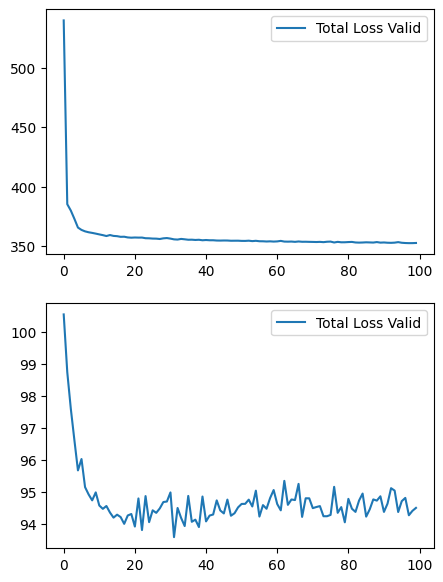

In [90]:
loss_file = open("data/loss_data_fb.pickle", "rb")
loss_dict = pickle.load(loss_file)
fig, ax = plt.subplots(2, 1, figsize=(5, 7))
# ax.plot(run_manager.loss_dict["train"]["total"], label="Total Loss Train")
ax[0].plot(loss_dict["train"]["total"], label="Total Loss Valid")
ax[0].legend()
ax[1].plot(loss_dict["valid"]["total"], label="Total Loss Valid")
ax[1].legend()

In [91]:
best = torch.load("data/lfadscheckpoints/best.pth")

In [80]:
best["run_manager"]

{'best': 92.27305018901825,
 'loss_dict': {'train': {'recon': [525.9685130399815,
    379.16545912798716,
    374.1997976864085,
    367.3316354190602,
    359.95618124569154],
   'kl': [10.404482273494494,
    1.514879917397218,
    1.5984326811397773,
    1.7910754259894874,
    1.925177349763758],
   'total': [540.0231170654297,
    385.0921585980584,
    379.7116169649012,
    372.7746025534236,
    365.3980865478515]},
  'valid': {'recon': [94.24201965332031,
    93.8820571899414,
    93.13920593261719,
    92.10542297363281,
    91.33120727539062],
   'kl': [1.6871390342712402,
    0.7042548656463623,
    0.7471256852149963,
    0.8833404779434204,
    0.9418429136276245],
   'total': [100.5440902709961,
    98.73673248291016,
    97.58856964111328,
    96.61231231689453,
    95.66294860839844]},
  'l2': [3.650125493021572,
   4.411820033017327,
   3.9133877543842086,
   3.6518931458978097,
   3.516729544190798]},
 'loss_weights': {'kl': {'weight': 1.0,
   'min': 0.0,
   'max': 1

In [81]:
best_model = LFADS_SingleSession_Net(
    input_size           = 59,
    factor_size          = hyperparams['model']['factor_size'],
    g_encoder_size       = hyperparams['model']['g_encoder_size'],
    c_encoder_size       = hyperparams['model']['c_encoder_size'],
    g_latent_size        = hyperparams['model']['g_latent_size'],
    u_latent_size        = hyperparams['model']['u_latent_size'],
    controller_size      = hyperparams['model']['controller_size'],
    generator_size       = hyperparams['model']['generator_size'],
    prior                = hyperparams['model']['prior'],
    clip_val             = hyperparams['model']['clip_val'],
    dropout              = hyperparams['model']['dropout'],
    do_normalize_factors = hyperparams['model']['normalize_factors'],
    max_norm             = hyperparams['model']['max_norm'],
    device               = device
).to(device)
best_model.load_state_dict(best["net"])

<All keys matched successfully>

In [82]:
out = best_model(torch.Tensor(spike_data))

In [83]:
posterior_means = best_model.g_posterior_mean.detach().numpy()

In [84]:
idx_cor = np.argwhere(valid_beh.Response.values=="Correct")[:,0]
idx_inc = np.argwhere(valid_beh.Response.values=="Incorrect")[:,0]

In [85]:
spike_data.shape

(1692, 15, 59)

In [86]:
len(idx_cor) + len(idx_inc)

1692

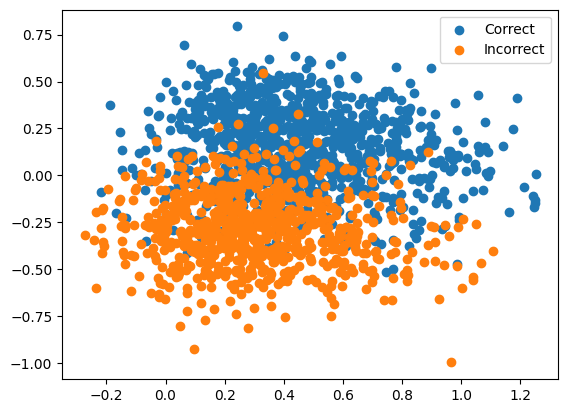

In [87]:
fig, ax = plt.subplots()
ax.scatter(posterior_means[idx_cor, 0], posterior_means[idx_cor, 1], label="Correct")
ax.scatter(posterior_means[idx_inc, 0], posterior_means[idx_inc, 1], label="Incorrect")
ax.legend()